In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Functions representing dz/dt

In [2]:
def ode_torch(t,y):
    '''Example differential equation
    Args: y is initial value
          t is time'''
    t = torch.tensor(t)
    m = y - 1/2 * torch.exp(t/2) * torch.sin(5*t) + 5*torch.exp(t/2)*torch.cos(5*t)
    return m

class mini_net(nn.Module):
    
    def __init__(self, W=torch.randn(1, requires_grad=True)):
        super(mini_net, self).__init__()
        self.W = W
        
    def forward(self, t, y):
        # This is dz/dt (change in hidden state with respect to time)
        return(sig(self.W * y))
    
def sig(x):
    return(torch.exp(x) / (torch.exp(x) + 1))

class ode_forward(nn.Module):
    
    def __init__(self):
        super(ode_forward, self).__init__()
#         self.W = nn.Parameter(torch.randn(6)) # parameters
        self.A = nn.Parameter(torch.randn(1)) # parameters
        self.B = nn.Parameter(torch.randn(1)) # parameters
        self.C = nn.Parameter(torch.randn(1)) # parameters
        self.D = nn.Parameter(torch.randn(1)) # parameters
        self.E = nn.Parameter(torch.randn(1)) # parameters
        self.F = nn.Parameter(torch.randn(1)) # parameters
        
    def forward(self,t,y):
        '''Example differential equation
        Args: y is initial value
              t is time'''
        t = torch.tensor(t)
        m = y - self.A * torch.exp(t/self.B) * torch.sin(self.C*t) +\
                                self.D*torch.exp(t/self.E)*torch.cos(self.F*t)
        return m

#### Solvers and augmented dynamics

In [73]:
def rk(fun, t_span, y0, h):
    '''Runge-Kutta 4th order method
        Args: - fun is derivative
              - t_span is tuple of start and end time
              - y0 is initial condition
              - h is step size (fixed in this case)'''
    w = torch.tensor([1/6, 1/3, 1/3, 1/6]) # weights
    w = w.expand(*y0.shape,4).permute(2,0,1)
    n_steps = int((t_span[1]-t_span[0])/h)
    y = y0 # set state to initial state
    t = t_span[0]
    all_y = [y0] # set state to initial state
    all_t = [t_span[0]]
    for _ in range(n_steps):
        k1 = h * fun(t     , y)
        k2 = h * fun(t+.5*h, y+.5*k1)
        k3 = h * fun(t+.5*h, y+.5*k2)
        k4 = h * fun(t+   h, y+   k3)
        t = t + h
        y = y + torch.sum(w*torch.stack([k1,k2,k3,k4],dim=0), dim=0)
        all_y.append(y)
        all_t.append(t)
    return torch.stack(all_y,dim=0), torch.tensor(all_t)

def euler(fun, t_span, y0, h):
    '''Function to compute numerical approximation of ODE. 
    Args: - dy_dt is a function which takes in y,t and represents the derivative
          - y0 and t0 represent the initial value and time, respectively
          - h is the step size (fixed, in this case)
          - n_steps is the number of steps to take'''
    n_steps = int((t_span[1]-t_span[0])/h)
    y = y0 # set state to initial state
    t = t_span[0]
    all_y = [y0] # set state to initial state
    all_t = [t_span[0]]
    for _ in range(n_steps):
        m = fun(t,y) # compute derivative at t0
#         print('t: {}, y: {}, m: {}, h: {}'.format(t,y,m,h))
        y = y + h*m # approximate next value
        t = t + h
        all_y.append(y) # record values
        all_t.append(t)  
    return(torch.stack(all_y, dim=0), torch.tensor(all_t))

class aug_dynamics():
    '''Class representing augmented dynamics of the system. Forward dynamics are governed by .
        To update parameters, we require derivative of loss with respect to the hidden state, 
        dL/dz (i.e., the adjoint). To compute the adjoint and the derivative of the loss with 
        respect to the parameters, we use will use the ODE solver with the augmented dynamics.'''
    
    def __init__(self, model):
        
        self.model = model # model to represent the dynamics of hidden state (i.e. dz/dt)

    def forward(self, t, aug_state):
        '''Forward pass of the dynamics. That is, evaluate the derivatives.
            Args: t is time
                  aug_state is tensor concatenation [a,z], i.e. adjoint state and hidden state
                  fun is function used to evaluate ode_vjp
            Returns: derivatives of adjoint and hidden state (respectively) with respect to time
                        i.e. torch.concat([da/dt, dz/dt])'''
        len_z = int(len(aug_state)/2)
        a = aug_state[:1,:].detach()
        z = aug_state[1:,:].detach().clone().requires_grad_(True)
        
        # Compute derivative of adjoint with respect to time
        dz_dt = self.model(t, z) # evaluate function 
        
        # Next, do backward step – this updates the gradients in the model parameters
        dz_dt.backward(-a) # get vector-jacobian product (vjp)
        
        return torch.cat([z.grad, dz_dt.detach()], dim=0)

#### Apply adjoint method

In [74]:
mod = mini_net() # instantiate mini neural net
# fun = ode_torch # Function representing forward dynamics (i.e. dz/dt)
fun = mod

torch.manual_seed(0)
y = torch.randn(1) # ground truth

# Parameters for Runge-Kutta
t_span = [0.,5.]
h = .5

# Forward pass
y_forward, t_forward = rk(fun=fun, t_span=t_span, y0=torch.tensor([[0.]]), h=h)

# Compute loss and adjoint at t=t_1
z1 = y_forward[-1,:,:].detach().requires_grad_(True)
L = torch.mean((y-z1)**2) # compute loss
L.backward() # compute adjoint at t = t_1

# Backward pass (using adjoint)
dyn = aug_dynamics(model=mod)
y,t = rk(fun=dyn.forward, t_span=t_span[::-1], y0=torch.cat([z1.grad, z1.detach()],dim=0), h=-h)

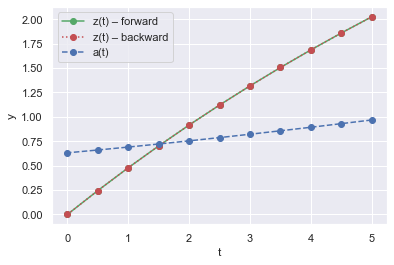

In [75]:
fig,ax=plt.subplots()
ax.plot(t_forward.numpy(),y_forward[:,0,0].detach().numpy(), label='z(t) – forward', color='g',marker='o', linestyle='-')
ax.plot(t.numpy(),y[:,1,0].detach().numpy(), label='z(t) – backward', color='r',marker='o', linestyle=':')
ax.plot(t.numpy(),y[:,0,0].detach().numpy(), label='a(t)', marker='o', linestyle='--')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.legend()
plt.show()

## Augmented dynamics with theta

#### Next solve for derivative of loss with respect to parameters

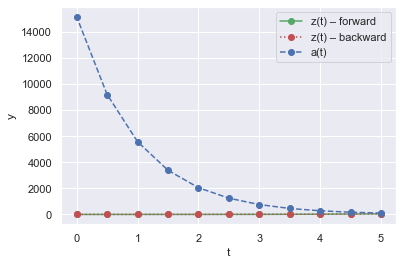

In [76]:
torch.manual_seed(0) # set random seed

mod = ode_forward() # create model
y, _ = rk(fun=ode_torch, t_span=t_span, y0=torch.tensor([[0.]]), h=h)
y = y[-1] # ground truth

# Parameters for Runge-Kutta
t_span = [0.,5.]
h = .5

# Forward pass
y_forward, t_forward = rk(fun=mod, t_span=t_span, y0=torch.tensor([[0.]]), h=h)

# Compute loss and adjoint at t=t_1
z1 = y_forward[-1,:,:].detach().requires_grad_(True)
loss = torch.mean((y-z1)**2) # compute loss (MSE)
loss.backward() # compute adjoint at t = t_1

# Backward pass (using adjoint)
dyn = aug_dynamics(model=mod)
yhat,t = rk(fun=dyn.forward, t_span=t_span[::-1], y0=torch.cat([z1.grad, z1.detach()],dim=0), h=-h)

fig,ax=plt.subplots()
ax.plot(t_forward.numpy(),y_forward[:,0,0].detach().numpy(), label='z(t) – forward', color='g',marker='o', linestyle='-')
ax.plot(t.numpy(),yhat[:,1,0].detach().numpy(), label='z(t) – backward', color='r',marker='o', linestyle=':')
ax.plot(t.numpy(),yhat[:,0,0].detach().numpy(), label='a(t)', marker='o', linestyle='--')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.legend()
plt.show()

## Train the model

In [77]:
torch.manual_seed(0) # set random seed

# Ground truth (differential equation)
y, _ = rk(fun=ode_torch, t_span=t_span, y0=torch.tensor([[0.]]), h=h)
y = y[-1] # ground truth

mod = ode_forward() # create model
# optimizer = torch.optim.SGD(mod.parameters(), lr=.0000000001)
optimizer = torch.optim.Adam(mod.parameters())

n_epochs = 100

loss_tracker = []
for epoch in range(1, n_epochs+1):
#     print(torch.cat(list(mod.parameters())).detach())

    # Parameters for Runge-Kutta
    t_span = [0.,5.]
    h = .5

    mod.zero_grad()
    with torch.no_grad():
        # Forward pass
        y_forward, t_forward = rk(fun=mod, t_span=t_span, y0=torch.tensor([[0.]]), h=h)

    # Compute loss and adjoint at t=t_1
    z1 = y_forward[-1,:,:].requires_grad_(True)
    loss = torch.mean((y-z1)**2) # compute loss
    loss.backward()
    loss_tracker.append(loss.item())
    
    # Backward pass (using adjoint)
    dyn = aug_dynamics(model=mod)
    yhat,t = rk(fun=dyn.forward, t_span=t_span[::-1], y0=torch.cat([z1.grad, z1.detach()],dim=0), h=-h)
    
    # Update parameters
    optimizer.step()
    
#     if (epoch%10 == 0):
#         print('Epoch {} loss: {}'.format(epoch, loss))
        
    if (epoch%50 == 0):
        print('Epoch {} loss: {}'.format(epoch, loss))
        print(z1.item())
#         for p in mod.parameters():
#             print(p.grad)

Epoch 50 loss: 3614.391357421875
57.65756607055664
Epoch 100 loss: 4922.38330078125
67.69745635986328


### Compare gradient to direct backpropogation

#### Using adjoint

In [78]:
torch.manual_seed(0) # set random seed

# Ground truth (differential equation)
y, _ = rk(fun=ode_torch, t_span=t_span, y0=torch.tensor([[0.]]), h=h)
y = y[-1] # ground truth

mod = ode_forward() # create model

# Parameters for Runge-Kutta
t_span = [0.,5.]
h = .5

mod.zero_grad()
with torch.no_grad():
    y_forward, t_forward = rk(fun=mod, t_span=t_span, y0=torch.tensor([[0.]]), h=h)

# Compute loss and adjoint at t=t_1
z1 = y_forward[-1,:,:].requires_grad_(True)
loss = torch.mean((y-z1)**2) # compute loss
loss.backward() # compute adjoint at t = t_1
    
# Backward pass (using adjoint)
dyn = aug_dynamics(model=mod)
yhat,t = rk(fun=dyn.forward, t_span=t_span[::-1], y0=torch.cat([z1.grad, z1.detach()],dim=0), h=-h)

for p in mod.parameters():
    print(p.grad)

tensor([-9623.9805])
tensor([70705.2734])
tensor([3762.6951])
tensor([-42525.0820])
tensor([2883.3574])
tensor([-11598.2012])


#### Backprop

In [79]:
torch.manual_seed(0) # set random seed
mod2 = ode_forward() # create model

mod2.zero_grad()
# with torch.no_grad():
y_forward, t_forward = rk(fun=mod2, t_span=t_span, y0=torch.tensor([[0.]]), h=h) # Forward pass

# Compute loss and adjoint at t=t_1
z1 = y_forward[-1,:,:]
loss = torch.mean((y-z1)**2) # compute loss
loss.backward() # compute adjoint at t = t_1

for p in mod2.parameters():
    print(p.grad)

tensor([1331.6857])
tensor([-9138.8701])
tensor([-562.6266])
tensor([5156.9263])
tensor([-397.1588])
tensor([1452.3306])


#### Train model with normal backprop

In [ ]:
torch.manual_seed(0) # set random seed
n_epochs = 3000

mod = ode_forward()
optimizer = torch.optim.Adam(mod.parameters())

loss_tracker = []
for epoch in range(1,n_epochs+1):
    
    mod.zero_grad()
    
    y_forward, _ = rk(fun=mod, t_span=t_span, y0=torch.tensor([[0.]]), h=h) # Forward pass
    
    # Compute loss at t=t_1
    z1 = y_forward[-1,:,:]
    loss = torch.mean((y-z1)**2) # compute loss
    loss.backward() # compute adjoint at t = t_1
    loss_tracker.append(loss.item())
    
    optimizer.step()
    
    if (epoch%300 == 0):
        print('Epoch {} loss: {}'.format(epoch, loss))
        print(z1.item())

Epoch 300 loss: 352.6011657714844
16.31543731689453
Epoch 600 loss: 115.8106918334961
8.299297332763672


### Mini example

In [ ]:
# f = ax + bt
class diff_eq(nn.Module):
    '''This class represents the 'f' function (change in hidden state with respect to time)'''
    
    def __init__(self):
        super(diff_eq, self).__init__()
        
        self.a = nn.Parameter(torch.tensor(3.))
        self.b = nn.Parameter(torch.tensor(1.))
        
    def forward(self, t, z):
        return(self.a*z + self.b*t)

In [ ]:
# Parameters for Runge-Kutta
t_span = [1.,2.]
h = .5
y = torch.tensor(10.) # ground truth

diffeq = diff_eq()

#### Adjoint method

In [ ]:
solver = euler

#### BACKPROPAGATION ####
diffeq.zero_grad()
y_forward, t_forward = solver(fun=diffeq, t_span=t_span, y0=torch.tensor([[2.]]), h=h) # Forward pass

loss=y_forward[-1,:,:]
loss.backward()

print('Backprop gradients:')
for p in diffeq.parameters():
    print(p.grad)
print()

    
#### ADJOINT METHOD ####
diffeq.zero_grad()
y_forward, t_forward = solver(fun=diffeq, t_span=t_span, y0=torch.tensor([[2.]]), h=h) # Forward pass

# Compute loss and adjoint at t=t_1
z1 = y_forward[-1,:,:].detach().clone().requires_grad_(True)
loss = z1
loss.backward() # compute adjoint at t = t_1
    
# # Backward pass (using adjoint)
dyn = aug_dynamics(model=diffeq)
yhat,t = solver(fun=dyn.forward, t_span=t_span[::-1], y0=torch.cat([z1.grad, z1.detach()],dim=0), h=-h)
# dyn.forward(t_span[0],yhat[-1]) # Compute gradient of f with respect to theta for first time step

print('Adjoint gradients:')
for p in diffeq.parameters():
    print(p.grad)

#### Compare to authors' code

In [ ]:
t_span=[1.,1.5,2.]
from torchdiffeq import odeint_adjoint, odeint
method = 'euler'

diffeq = diff_eq()
diffeq.zero_grad()
yhat = odeint(func=diffeq, y0=torch.tensor(2.), t = torch.tensor(t_span), method=method)
yhat[-1].backward()

print('Backpropagation gradients:')
for p in diffeq.parameters():
    print(p.grad)
print()
    
diffeq = diff_eq()
diffeq.zero_grad()
yhat = odeint_adjoint(func=diffeq, y0=torch.tensor(2.), t = torch.tensor(t_span), method=method)
yhat[-1].backward()

print('Adjoint gradients:')
for p in diffeq.parameters():
    print(p.grad)